# Prediction of Survival Rate in Titanic Dataset

## Import relevant components

In [103]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

# Ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

np.random.seed(100)

## Data Preparation
### 1. Load Data
Read data from csv file.

In [104]:
df = pd.read_csv('titanic/train.csv')
df_test = pd.read_csv('titanic/test.csv')

### 2. Data Dimensions
1. Training dataset consists of 891 samples. Each sample has 12 features. Many of these entries are null.
2. Test dataset consists of 418 samples. Each sample has 11 features. Many of these entries are null.

In [105]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [107]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [108]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### 3. Add columns
1. Person - To identify child
2. Group - To identify if a passenger was alone or with family

In [109]:
# Person column
def person(passenger):
    age, sex = passenger
    if age < 16:
        return 'child'
    else:
        return sex
df['Person'] = df[['Age', 'Sex']].apply(person, axis=1)

# Group column
def group(passenger):
    sibsp, parch = passenger
    if sibsp or parch !=0:
        return 1
    else:
        return 0
df['Group'] = df[['SibSp','Parch']].apply(group, axis = 1)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male,0


## Data Distribution among various categories
### 1. Class
Majority of passengers onboard were from third class.

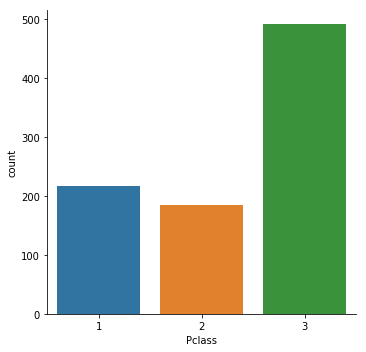

In [8]:
sns.catplot('Pclass', data = df, kind = "count")

### 2. Sex
Majority of passengers were male.

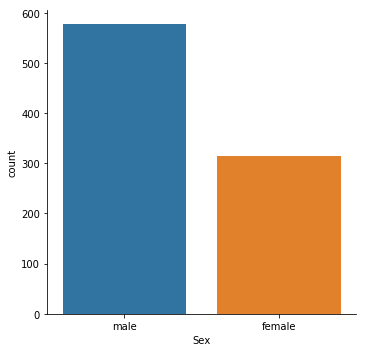

In [9]:
sns.catplot('Sex', data = df, kind = "count")

### 3. Age

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


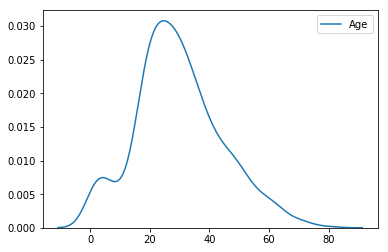

In [10]:
sns.kdeplot(df['Age'])

In [11]:
df['Age'].mean()

29.69911764705882

### 4. Group
Majority of passengers were alone.

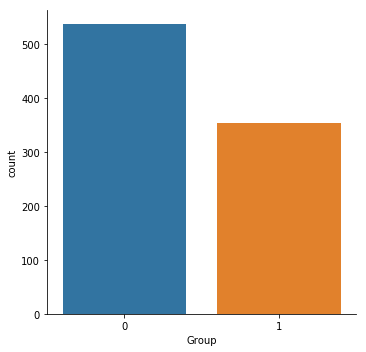

In [12]:
f = sns.catplot('Group', data = df, kind = "count")

### 5. Station
Majority of them embarked from station Southampton.

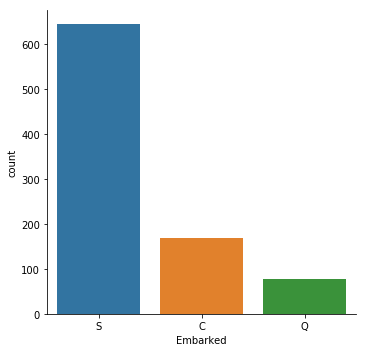

In [13]:
sns.catplot('Embarked', data = df, kind = "count")

### 6. Combinations
1. Third class has the highest number of males, females and children.
2. From station Q, almost all passengers belonged to third class.

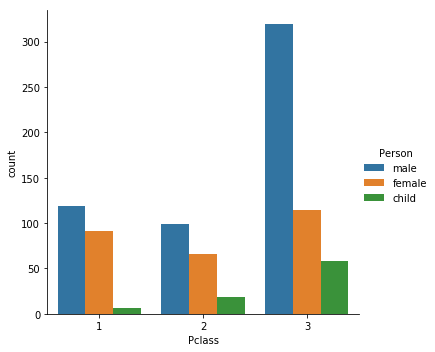

In [14]:
sns.catplot(x = 'Pclass', hue = 'Person', data = df, kind = "count")

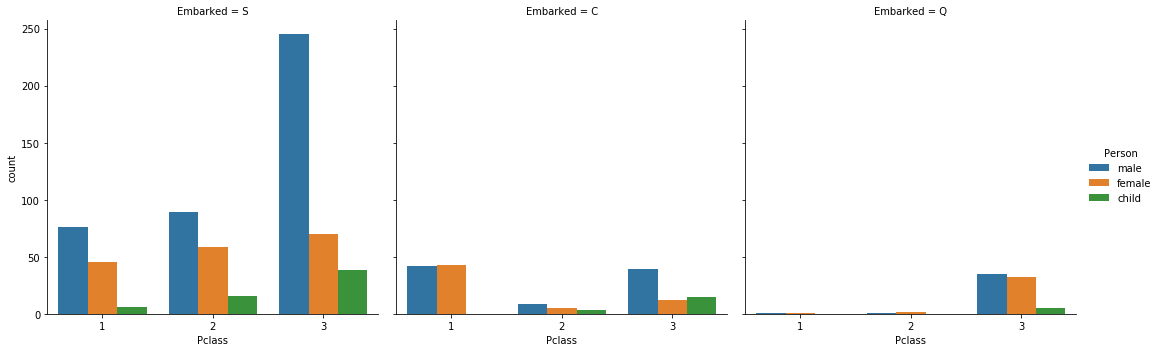

In [15]:
sns.catplot(x = 'Pclass', hue = 'Person', col = 'Embarked', data = df, kind = "count")

## Factors Affecting Survival
Majority of those onboard failed to survive.

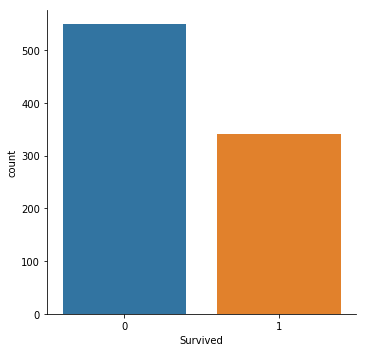

In [16]:
sns.catplot('Survived', data = df, kind = "count")

### 1. Class
Passengers from first class had highest survival rate. Passengers from 3rd class had lowest survival rate.

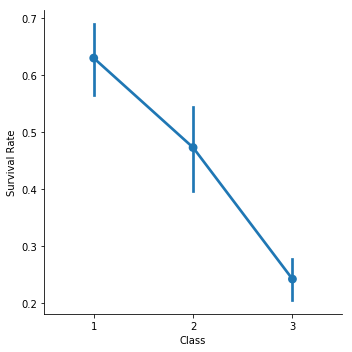

In [17]:
f = sns.catplot(x='Pclass', y='Survived', data = df, kind = "point")
f.set_axis_labels("Class", "Survival Rate")

### 2. Sex
Women had much higher survival rate than men.

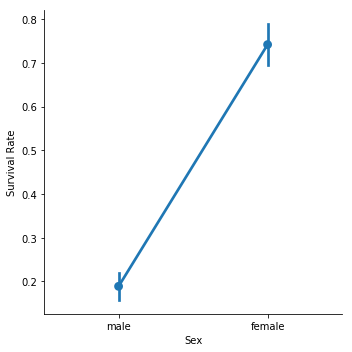

In [18]:
f = sns.catplot(x='Sex', y='Survived', data = df, kind = "point")
f.set_axis_labels("Sex", "Survival Rate")

### 3. Age
Survival rate is decreasing with age.

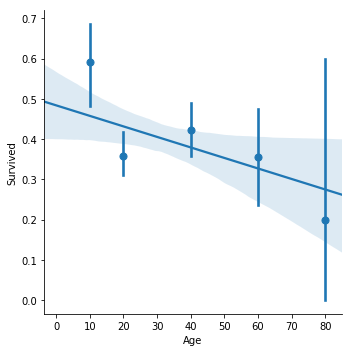

In [19]:
generations = [10,20,40,60,80]
sns.lmplot(x='Age', y='Survived',data = df, x_bins = generations)

### 4. Class, Sex and Age
1. Women and children had much higher survival rates in all the classes.
2. Men from 1st class had higher survival rate than those from other classes.
3. Passengers from 3rd class have lowest survival rate because of highest % of males in 3rd class and survival rate of males being lower.
4. Older women had higher survival rate than older men.
5. Older persons from 1st class had higher survival rates than those from other classes.

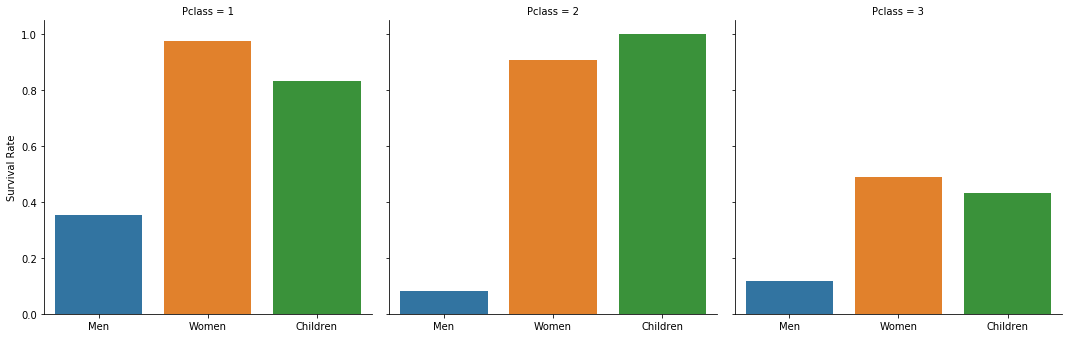

In [20]:
f = sns.catplot(x='Person', y='Survived', col = 'Pclass',data = df, kind = "bar", ci=None)
f.set_axis_labels("", "Survival Rate")
f.set_xticklabels(["Men","Women","Children"])

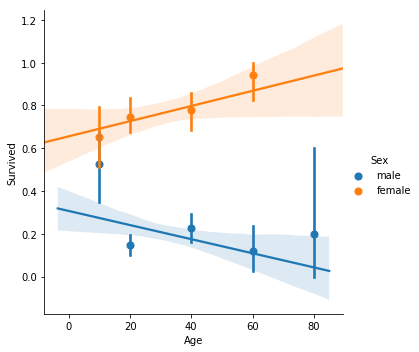

In [21]:
generations = [10,20,40,60,80]
sns.lmplot(x='Age', y='Survived',hue = 'Sex',data = df, x_bins = generations)

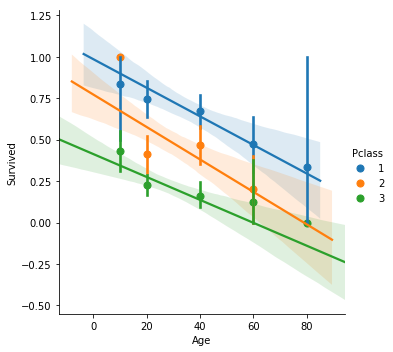

In [22]:
generations = [10,20,40,60,80]
sns.lmplot(x='Age', y='Survived',hue = 'Pclass',data = df, x_bins = generations)

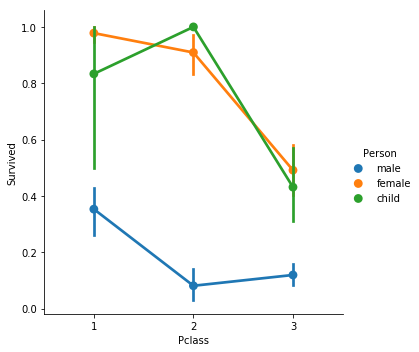

In [23]:
sns.catplot(x='Pclass', y='Survived', hue = 'Person',data = df, kind = "point")

### 5. Group
Those with family had a much higher survival rate than those alone.

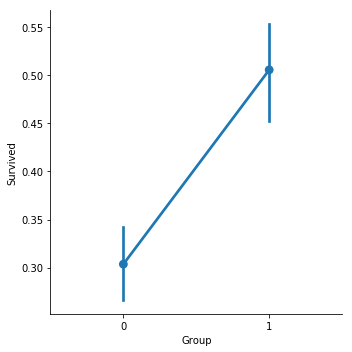

In [24]:
sns.catplot(x='Group', y='Survived',data = df, kind = "point")

### 6. Fare

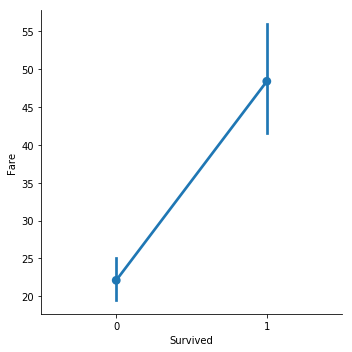

In [25]:
sns.catplot(x='Survived', y='Fare', data = df, kind = 'point')

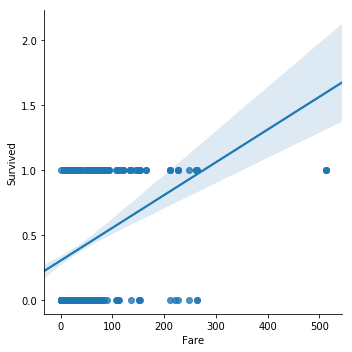

In [26]:
sns.lmplot(x='Fare', y='Survived',data = df)

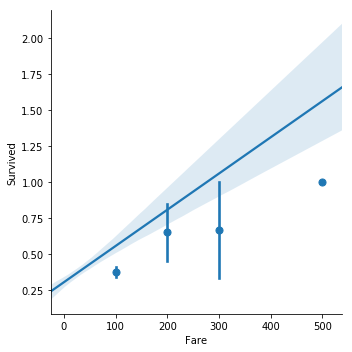

In [27]:
fare = [100,200,300,400,500]
sns.lmplot(x='Fare', y='Survived', data = df, x_bins = fare)

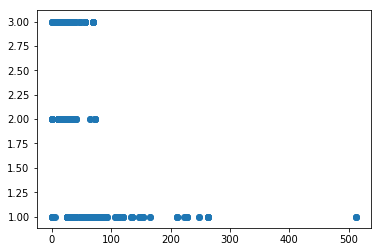

In [28]:
plt.scatter(df['Fare'], df['Pclass'])

### 7. Deck
No clear influence of deck number on survival rate.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Group,Deck
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,1,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,1,C
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male,0,E
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,child,1,G
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,female,0,C


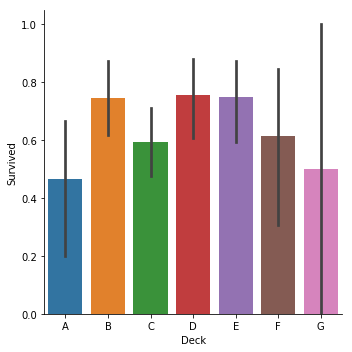

In [29]:
# Drop rows having null cabin values
null_cabin_indices = df[df['Cabin'].isnull()].index.tolist()
df1 = df.drop(null_cabin_indices, axis = 0)

# Get first letter of cabin
levels=[]
for level in df1['Cabin']:
    levels.append(level[0])    

# Plot survival as function of decks
df1['Deck'] = levels
sns.catplot(x='Deck', y='Survived', data = df1, kind = "bar", order = ['A','B','C','D','E','F','G'])
df1.head()

### 8. Station
Survival rate for those embarked from station C was highest.

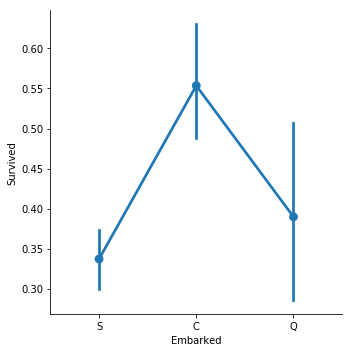

In [30]:
sns.catplot(x='Embarked', y='Survived', data = df, kind = 'point')

## Model Selection

### 1. Data Preprocessing
1. Impute missing values
2. One hot encoding
3. Normalize features

In [110]:
"""
    Impute missing values
"""
# Age
imp = SimpleImputer(strategy='mean')
imp.fit(np.vstack(df['Age']))
df['Age'] = imp.transform(np.vstack(df['Age']))

# Station
imp = SimpleImputer(strategy='most_frequent')
imp.fit(df[['Embarked']])
df['Embarked'] = imp.transform(df[['Embarked']])


"""
    One hot encoding
""" 
onehot_encoder = OneHotEncoder(sparse = False)

# Class
class_ = onehot_encoder.fit_transform(df[['Pclass']])
df[['Class1', 'Class2', 'Class3']] = pd.DataFrame(class_)
#df[['Class1', 'Class2', 'Class3']] = pd.get_dummies(df['Pclass'])

# Sex
sex = onehot_encoder.fit_transform(df[['Sex']])
df[['Female', 'Male']] = pd.DataFrame(sex)

# Embarked
embarked = onehot_encoder.fit_transform(df[['Embarked']])
df[['Station1_C', 'Station2_Q', 'Station3_S']] = pd.DataFrame(embarked)

# Child
def child(passenger):
    age = passenger
    if age < 16:
        return 1
    else:
        return 0
df['Child'] = df['Age'].apply(child)
                                                        

"""
    Normalize Features: Use only with Logistic Regression and SVM. Not with tree based classifiers.
"""
def normalize_features():
    # Age
    df['Age'] = np.log(df['Age'])
    df['Age'] = (df['Age'] - df['Age'].mean()) / (df['Age'].max() - df['Age'].min())

    # Fare
    df['Fare'] = np.log(df['Fare']+1)
    df['Fare'] = (df['Fare'] - df['Fare'].mean()) / (df['Fare'].max() - df['Fare'].min())

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Person         891 non-null object
Group          891 non-null int64
Class1         891 non-null float64
Class2         891 non-null float64
Class3         891 non-null float64
Female         891 non-null float64
Male           891 non-null float64
Station1_C     891 non-null float64
Station2_Q     891 non-null float64
Station3_S     891 non-null float64
Child          891 non-null int64
dtypes: float64(10), int64(7), object(6)
memory usage: 160.2+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Group,Class1,Class2,Class3,Female,Male,Station1_C,Station2_Q,Station3_S,Child
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0


### 2. Feature Identification
1. Use Pclass, Sex, Age, SibSp, Parch, Group, Fare, Child, Embarked as features as these have clearly influenced the survival rates. 
2. These features also have significant correlation with survival.

In [111]:
X = df[['Pclass','Class1','Class2','Class3','Female','Male','Age','SibSp','Parch','Group','Fare','Child',
        'Station1_C','Station2_Q','Station3_S']]
y = df['Survived']

# Check correlations which are significant (> 1.96/sqrt(n)= 0.06)
print("Female:", df['Female'].corr(df['Survived']))
print("Male:", df['Male'].corr(df['Survived']))
print("Pclass:", df['Pclass'].corr(df['Survived']))
print("Class1:", df['Class1'].corr(df['Survived']))
print("Class2:", df['Class2'].corr(df['Survived']))
print("Class3:", df['Class3'].corr(df['Survived']))
print("Fare:", df['Fare'].corr(df['Survived']))
print("Child:", df['Child'].corr(df['Survived']))
print("Age:", df['Age'].corr(df['Survived']))
print("Parch:", df['Parch'].corr(df['Survived']))
print("SibSp:", df['SibSp'].corr(df['Survived']))
print("Group:", df['Group'].corr(df['Survived']))
print("Station1_C:", df['Station1_C'].corr(df['Survived']))
print("Station2_Q:", df['Station2_Q'].corr(df['Survived']))
print("Station3_S:", df['Station3_S'].corr(df['Survived']))

def feature_importance(estimator):
    feature_imp = pd.Series(estimator.feature_importances_, list(X.columns)).sort_values(ascending = False)
    feature_imp.plot(kind = 'bar', title = 'Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

Female: 0.5433513806577555
Male: -0.5433513806577555
Pclass: -0.33848103596101475
Class1: 0.2859037677837432
Class2: 0.0933485724119293
Class3: -0.3223083573729708
Fare: 0.2573065223849625
Child: 0.13610698067319432
Age: -0.06980851528714314
Parch: 0.08162940708348372
SibSp: -0.035322498885735645
Group: 0.20336708569989206
Station1_C: 0.16824043121823268
Station2_Q: 0.0036503826839719387
Station3_S: -0.1496827232706859


### 3. Model Building
#### 1. Logistic Regression

In [80]:
logR = LogisticRegression(random_state=0)
logR.fit(X, y)
print("Train Accuracy:", logR.score(X, y))
scores_logR = cross_val_score(logR, X, y, cv = 10 )
print("CV Accuracy: {} (+/-) {}".format(scores_logR.mean(), scores_logR.std() * 2))

Train Accuracy: 0.8125701459034792
CV Accuracy: 0.8070247418000228 (+/-) 0.05486338386519307


#### 2.  Linear SVC

In [81]:
linearsvc = LinearSVC(dual = False, C=1, random_state=0)
linearsvc.fit(X, y)
print("Train Accuracy:", linearsvc.score(X, y))
scores_lsvc = cross_val_score(linearsvc, X, y, cv = 10 )
print("CV Accuracy: {} (+/-) {}".format(scores_lsvc.mean(), scores_lsvc.std() * 2))

Train Accuracy: 0.8114478114478114
CV Accuracy: 0.8070247418000228 (+/-) 0.05202882703541129


#### 3. SVC with kernel

In [82]:
svc = SVC(C = 5, random_state=0)
svc.fit(X, y)
print("Train Accuracy:", svc.score(X, y))
scores_svc = cross_val_score(svc, X, y, cv = 10 )
print("CV Accuracy: {} (+/-) {}".format(scores_svc.mean(), scores_svc.std() * 2))

Train Accuracy: 0.9158249158249159
CV Accuracy: 0.7409059698104642 (+/-) 0.0735800680583204


#### 4. K Nearest Neighbors

In [83]:
neigh = KNeighborsClassifier(n_neighbors=6, weights = 'distance')
neigh.fit(X, y)
print("Train Accuracy:", neigh.score(X, y))
scores_neigh = cross_val_score(neigh, X, y, cv = 10 )
print("CV Accuracy: {} (+/-) {}".format(scores_neigh.mean(), scores_neigh.std() * 2))

Train Accuracy: 0.9820426487093153
CV Accuracy: 0.735312961071388 (+/-) 0.10280543135920849


#### 5. Decision Tree

In [84]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X, y)
print("Train Accuracy:", tree.score(X, y))
scores_tree = cross_val_score(tree, X, y, cv = 10 )
print("CV Accuracy: {} (+/-) {}".format(scores_tree.mean(), scores_tree.std() * 2))

Train Accuracy: 0.9820426487093153
CV Accuracy: 0.7867997389626604 (+/-) 0.06611915171120235


#### 6. Random Forest

In [85]:
forest = RandomForestClassifier(n_estimators=100,random_state=0)
forest.fit(X, y)
print("Train Accuracy:", forest.score(X, y))
scores_forest = cross_val_score(forest, X, y, cv = 10 )
print("CV Accuracy: {} (+/-) {}".format(scores_forest.mean(), scores_forest.std() * 2))

Train Accuracy: 0.9820426487093153
CV Accuracy: 0.8048777096810804 (+/-) 0.0954871422959098


#### 7. AdaBoost

In [86]:
boost = AdaBoostClassifier(n_estimators = 200, random_state=0)
boost.fit(X, y)
print("Train Accuracy:", boost.score(X, y))
scores_boost = cross_val_score(boost, X, y, cv = 10 )
print("CV Accuracy: {} (+/-) {}".format(scores_boost.mean(), scores_boost.std() * 2))

Train Accuracy: 0.8518518518518519
CV Accuracy: 0.8171620701395982 (+/-) 0.06138044265364307


#### 8. Gradient Boost

Train Accuracy: 0.8900112233445566
AUC: 0.8955768794004089
CV Accuracy: 0.8204864409971393 (+/-) 0.039039385813709714


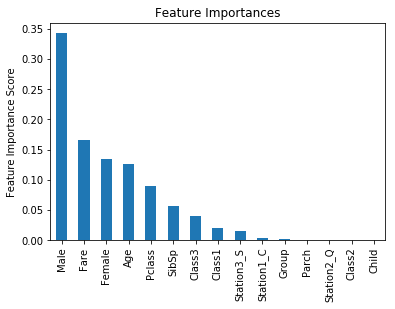

In [112]:
grad = GradientBoostingClassifier(random_state = 0)
grad.fit(X, y)
print("Train Accuracy:", grad.score(X, y)) # gives same value as accuracy_score
print("AUC:", roc_auc_score(grad.predict(X), y))
scores_grad = cross_val_score(grad, X, y, cv = 5 )
print("CV Accuracy: {} (+/-) {}".format(scores_grad.mean(), scores_grad.std() * 2)) # 95% confidence interval
feature_importance(grad)

Highest CV accuracy is obtained for Gradient Boost Classifier. So choose this model and fine tune it to further improve accuracy.

### 4. Parameter Tuning in GBM
#### 1. Tune Boosting parameters
1. learning_rate
2. n_estimators
3. subsample

For default learning rate = 0.1, tune no of trees/estimators. Then use these values to tune tree-specific parameters. Finally, lower the learning rate and increase the estimators proportionally to get more robust models.

Best parameter:{'n_estimators': 100}, Best CV score:0.8746208352797551


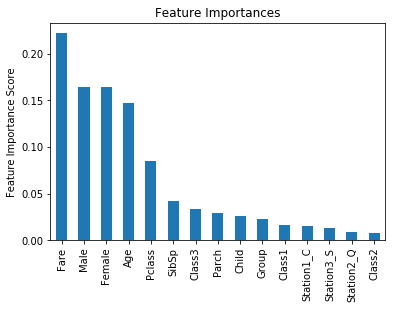

In [113]:
param_test1 = {'n_estimators': range(20, 300, 10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=4,
                        min_samples_leaf=1, max_depth=5, max_features='sqrt', subsample=0.8, random_state=0),  
                        param_grid = param_test1, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)
gsearch1.fit(X,y)
print("Best parameter:{}, Best CV score:{}".format(gsearch1.best_params_, gsearch1.best_score_))
feature_importance(gsearch1.best_estimator_)

Importance given to various features is much more spread out when compared to the baseline model. Thus now we are able to derive value from many more features. This increases the robustness of model.

#### 2. Tune Tree-specific parameters 
1. max_depth and min_samples_split
2. min_samples_leaf
3. max_features

Best parameter:{'max_depth': 5, 'min_samples_split': 4}, Best CV score:0.8746208352797551


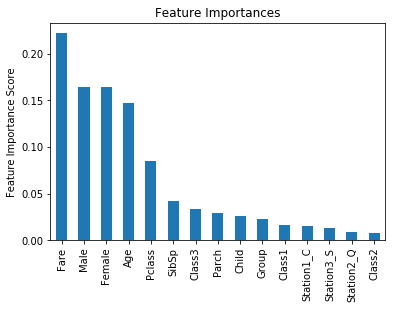

In [114]:
# Tune max_depth:(5-8) and min_samples_split:(0.5-1% of total values)
param_test2 = {'max_depth': range(3, 8, 1), 'min_samples_split': range(2, 10, 1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, 
                                    max_features='sqrt', subsample=0.8, random_state=0), 
                                    param_grid = param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(X,y)
print("Best parameter:{}, Best CV score:{}".format(gsearch2.best_params_, gsearch2.best_score_))
feature_importance(gsearch2.best_estimator_)

Best parameter:{'min_samples_leaf': 5}, Best CV score:0.8748264645090005


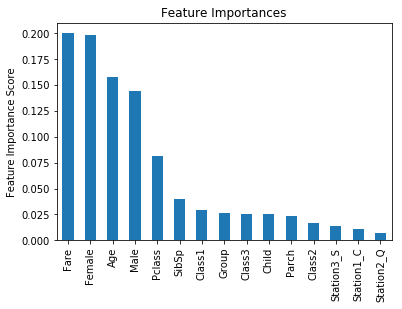

In [115]:
# Tune min_samples_leaf
param_test3 = {'min_samples_leaf': range(1, 10, 1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5,
                                    min_samples_split=4, max_features='sqrt', subsample=0.8, random_state=0), 
                                    param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(X,y)
print("Best parameter:{}, Best CV score:{}".format(gsearch3.best_params_, gsearch3.best_score_))
feature_importance(gsearch3.best_estimator_)

Best parameter:{'max_features': 3}, Best CV score:0.8748264645090005


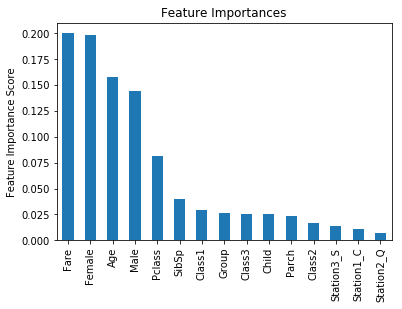

In [116]:
# Tune max_features - sqrt of total no of features works great but should check upto 30-40% of total features.
param_test4 = {'max_features': range(1, 8, 1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, 
                                    min_samples_split=4, min_samples_leaf=5, subsample=0.8, random_state=0),
                                    param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch4.fit(X,y)
print("Best parameter:{}, Best CV score:{}".format(gsearch4.best_params_, gsearch4.best_score_))
feature_importance(gsearch4.best_estimator_)

#### 3. Back to tuning boosting parameters

Best parameter:{'subsample': 0.6}, Best CV score:0.8748910110514091


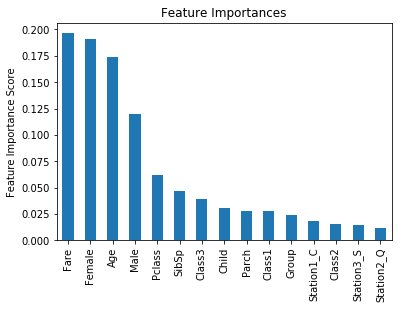

In [134]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, 
                                    min_samples_split=4, min_samples_leaf=5, max_features=3, random_state=0),
                                    param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch5.fit(X,y)
print("Best parameter:{}, Best CV score:{}".format(gsearch5.best_params_, gsearch5.best_score_))
feature_importance(gsearch5.best_estimator_)

Best parameter:{'learning_rate': 0.1, 'n_estimators': 110}, Best CV score:0.8751380306265452


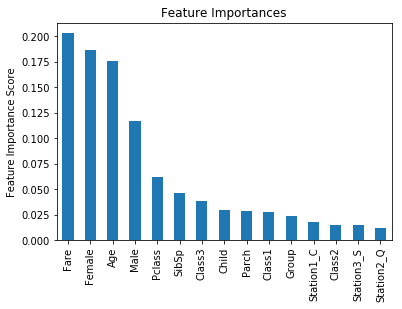

In [144]:
param_test6 = {'learning_rate':[0.05, 0.1, 0.2], 'n_estimators': [55, 100,110, 220]}
gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(max_depth=5,min_samples_split=4, 
                                    min_samples_leaf=5, max_features=3, subsample = 0.6, random_state=0),
                                    param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch6.fit(X,y)
print("Best parameter:{}, Best CV score:{}".format(gsearch6.best_params_, gsearch6.best_score_))
feature_importance(gsearch6.best_estimator_)

Best parameter:{'learning_rate': 0.1, 'n_estimators': 110}, Best CV score:0.8767282020325264


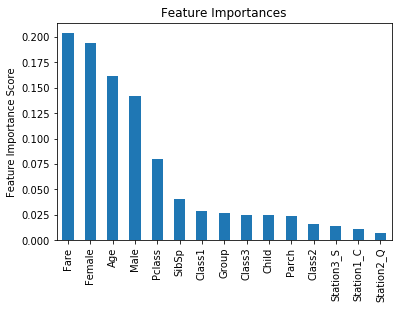

In [127]:
param_test7 = {'learning_rate':[0.05, 0.1, 0.2], 'n_estimators': [55, 100,110, 220]}
gsearch7 = GridSearchCV(estimator = GradientBoostingClassifier(max_depth=5,min_samples_split=4, 
                                    min_samples_leaf=5, max_features=3, subsample = 0.8, random_state=0),
                                    param_grid = param_test7, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch7.fit(X,y)
print("Best parameter:{}, Best CV score:{}".format(gsearch7.best_params_, gsearch7.best_score_))
feature_importance(gsearch7.best_estimator_)

### Prediction using best model

In [47]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Prepare test set

In [128]:
# Add columns
df_test['Group'] = df_test[['SibSp','Parch']].apply(group, axis = 1)
df_test['Child'] = df_test['Age'].apply(child)

"""
    Impute missing values
"""
# Age & Fare
imp = SimpleImputer(strategy='mean')
imp.fit(np.vstack(df_test['Age']))
df_test['Age'] = imp.transform(np.vstack(df_test['Age']))
imp.fit(np.vstack(df_test['Fare']))
df_test['Fare'] = imp.transform(np.vstack(df_test['Fare']))

"""
    One hot encoding
""" 
onehot_encoder = OneHotEncoder(sparse = False)

# Class
class_ = onehot_encoder.fit_transform(df_test[['Pclass']])
df_test[['Class1', 'Class2', 'Class3']] = pd.DataFrame(class_)

# Sex
sex = onehot_encoder.fit_transform(df_test[['Sex']])
df_test[['Female', 'Male']] = pd.DataFrame(sex)

# Embarked
embarked = onehot_encoder.fit_transform(df_test[['Embarked']])
df_test[['Station1_C', 'Station2_Q', 'Station3_S']] = pd.DataFrame(embarked)

df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Group          418 non-null int64
Child          418 non-null int64
Class1         418 non-null float64
Class2         418 non-null float64
Class3         418 non-null float64
Female         418 non-null float64
Male           418 non-null float64
Station1_C     418 non-null float64
Station2_Q     418 non-null float64
Station3_S     418 non-null float64
dtypes: float64(10), int64(6), object(5)
memory usage: 68.7+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Group,Child,Class1,Class2,Class3,Female,Male,Station1_C,Station2_Q,Station3_S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


#### Predict Survival Rate

In [145]:
survived = gsearch7.best_estimator_.predict(df_test[['Pclass','Class1','Class2','Class3','Female','Male','Age','SibSp','Parch','Group','Fare','Child',
        'Station1_C','Station2_Q','Station3_S']])
survived

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [146]:
df_final = pd.DataFrame({'PassengerId':df_test['PassengerId'], 'Survived':survived})

In [147]:
df_final.to_csv('Prediction.csv', index = False)

In [148]:
### Scored 0.75598